In [1]:
# Add utils libraries to program 
import sys
sys.path.append('/home/class_NI2021/ctxctl_contrib_2023')

# Imports all necessary libraries (samna and utils)
import samna
import samna.dynapse1 as dyn1
from dynapse1constants import *
import dynapse1utils as ut
import netgen as n
import params
import time
import math
import numpy as np

In [2]:
# Check which dynapse are free
devices = samna.device.get_unopened_devices()
for i in range(len(devices)):
        print("["+str(i)+"]: ", devices[i], "serial_number", devices[i].serial_number)

[0]:  Bus 1 Device 119 Dynapse1DevKit serial_number 00000011
[1]:  Bus 1 Device 118 Dynapse1DevKit serial_number 00000000


In [3]:
# Open DYNAP-SE1 board selected (by ports) and get Dynapse1Model, without GUI (GUI = False)
model, _ = ut.open_dynapse1(gui=False, sender_port=17349, receiver_port=15347, select_device=True) # dynapse = 11

[0]:  Bus 1 Device 119 Dynapse1DevKit serial_number 00000011
[1]:  Bus 1 Device 118 Dynapse1DevKit serial_number 00000000
Sender port: tcp://0.0.0.0:17349
Receiver port: tcp://0.0.0.0:15347
Opened device name: Dynapse1DevKit
SamnaNode ID: 1
PythonNode ID: 2


In [30]:
# Needed functions
def get_bin_representation(input_ids):
    binary_ids = []
    max_num_digits = 0
    # Create a copy of input neurons ids to reverse and begin with the bigger one
    neurons_id = input_ids.copy()
    neurons_id.reverse()
    # For each neuron id
    for id in neurons_id:
        res = id
        binary_id = []
        # Calculate the binary representation
        while res > 1:
            binary_id.append(res % 2)
            res = res // 2
        if res == 0:
            binary_id.append(0)
        else:
            binary_id.append(1)
        # Adjust all binary representations to the number with the max number of digits
        if max_num_digits == 0:
            max_num_digits = len(binary_id)
        elif max_num_digits > len(binary_id):
            diff = max_num_digits - len(binary_id)
            for i in range(diff):
                binary_id.append(0)
        # Store the binary representation, the first element is the less significative and the last is the most significative (reverse the original representation)
        binary_ids.append(binary_id)
    binary_ids.reverse()
    return binary_ids

def get_syn_ca1(input_neuron_ids):
    # Get binary representation
    binary_ids = get_bin_representation(input_neuron_ids)
    pre_exc_syn = []
    post_exc_syn = []
    # Get pre and post exc synapses from binary representation
    for pre, binary_id in enumerate(binary_ids):
        for post, id in enumerate(binary_id):
            if id == 1:
                pre_exc_syn.append(pre)
                post_exc_syn.append(post)

    return pre_exc_syn, post_exc_syn

In [31]:
# Initialization of all parameters
paramGroup = params.gen_clean_param_group()
for chip in range(4):
    for core in range(4):
        model.update_parameter_group(paramGroup, chip, core)

In [32]:
#   0 = 3 - 2 decoder
#   1 = 7 - 3 decoder
exp_id = 1

# To create a network:
#   1) Create populations of neurons (chip id, core id, neurons id, generator?)
#       Decoder 7 input - CA1 pop - 3 output
#       - Spike generator populations 
if exp_id == 0:
    generator_neuron_ids = [1, 2, 3]
elif exp_id == 1:
    generator_neuron_ids = [1, 2, 3, 4, 5, 6, 7]
spikegen_pop = n.NeuronGroup(0 ,0, generator_neuron_ids, True)
#       - DPI neuron populations
ca1_pop_chip = 0
ca1_pop_core = 1
if exp_id == 0:
    ca1_neuron_ids = [12, 13]
elif exp_id == 1:
    ca1_neuron_ids = [12, 13, 14]
ca1_pop = n.NeuronGroup(ca1_pop_chip , ca1_pop_core, ca1_neuron_ids, False)


#   2) Create the network configuration for Dynapse (based on populations created and used to add synapses between them)
net_gen = n.NetworkGenerator()

#   3) Add synapses
#       - Calculate the excitatory and inhibitory synapses
pre_exc_syn, post_exc_syn = get_syn_ca1(generator_neuron_ids)
#       - gen-ca1 -> excitatory
net_gen.add_connections_from_list(spikegen_pop.neurons, ca1_pop.neurons, dyn1.Dynapse1SynType.AMPA, pre_ids = pre_exc_syn, post_ids = post_exc_syn)

In [33]:
print("- Network: ")
print(net_gen.network)

- Network: 
Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C0c1n12: [('C0c0s1', 'AMPA'), ('C0c0s3', 'AMPA'), ('C0c0s5', 'AMPA'), ('C0c0s7', 'AMPA')]
C0c1n13: [('C0c0s2', 'AMPA'), ('C0c0s3', 'AMPA'), ('C0c0s6', 'AMPA'), ('C0c0s7', 'AMPA')]
C0c1n14: [('C0c0s4', 'AMPA'), ('C0c0s5', 'AMPA'), ('C0c0s6', 'AMPA'), ('C0c0s7', 'AMPA')]



In [34]:
# Create configuration based on network created (if not valid raise an exception and close the device)
config = net_gen.make_dynapse1_configuration()

# Apply configuration
model.apply_configuration(config)

In [35]:
# Initialize custom parameters for a core and a chip:
paramGroup = dyn1.Dynapse1ParameterGroup() 

# PRE CORE
#   * coarse_value: to tune the parameters in a coarse way
#   * fine_value: to tune the parameters in a fine way
#   * param_name 
#       - Neuron:
#           * THR (IF_THR_N): the gain factor of neuron
paramGroup.param_map["IF_THR_N"].coarse_value = 5
paramGroup.param_map["IF_THR_N"].fine_value = 100
#           * RFR (IF_RFR_N): refractory period
paramGroup.param_map["IF_RFR_N"].coarse_value = 7
paramGroup.param_map["IF_RFR_N"].fine_value = 255
#           * TAU1 (IF_TAU1_N) and TAU2 (IF_TAU2_N): the membrane time-constant of leakage current or how much current is constantly leaked away
paramGroup.param_map["IF_TAU1_N"].coarse_value = 3
paramGroup.param_map["IF_TAU1_N"].fine_value = 15
#           * DC (IF_DC_P): injection of constant current
paramGroup.param_map["IF_DC_P"].coarse_value = 0
paramGroup.param_map["IF_DC_P"].fine_value = 0
#       - Synapses:
#           - AMPA (IE_F_P): Fast excitatory synapses
#               * TAU (NPDPIE_TAU_F_P or NPDPII_TAU_F_P)
paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 4
paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value =  80
#               * THR (NPDPIE_THR_F_P or NPDPII_THR_F_P)
paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 4
paramGroup.param_map["NPDPIE_THR_F_P"].fine_value =  80 
#               * WEIGHT (PS_WEIGHT_EXC_F_N or PS_WEIGHT_INH_F_N)
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 7
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 255 

# Apply the custom parameters to the core
model.update_parameter_group(paramGroup, ca1_pop.chip_id, ca1_pop.core_id)

In [36]:
"""
Experiments:
    0 - test with ladder input
"""
experiment = 0

# Create the generator of spikes: set_fpga_spike_gen(*)
#   * generator object
fpga_spike_gen = model.get_fpga_spike_gen()
#   * list of input spikes in seconds = spike list
if experiment == 0:
    num_rep = 5
    if exp_id == 0:
        spike_time_list = np.sort(np.concatenate((np.linspace(0, 0.005, num_rep), np.linspace(0.1, 0.105, num_rep),
                                    np.linspace(0.2, 0.205, num_rep)), axis=None), axis=None)
        time_to_last_spike = 0.205
        total_time = 1
    elif exp_id == 1:
        spike_time_list = np.sort(np.concatenate((np.linspace(0, 0.005, num_rep),
                                    np.linspace(0.1, 0.105, num_rep),
                                    np.linspace(0.2, 0.205, num_rep),
                                    np.linspace(0.3, 0.305, num_rep),
                                    np.linspace(0.4, 0.405, num_rep),
                                    np.linspace(0.5, 0.505, num_rep),
                                    np.linspace(0.6, 0.605, num_rep)), axis=None), axis=None)
        time_to_last_spike = 0.605
        total_time = 1
else:
    spike_time_list = []
    time_to_last_spike = 0
#   * list of generator neuron ids (one element per spike in spike list)
if experiment == 0:
    if exp_id == 0:
        gen_neuron_ids = ([1]*(num_rep) + [2]*(num_rep) + [3]*(num_rep))
    elif exp_id == 1:
        gen_neuron_ids = ([1]*(num_rep) + [2]*(num_rep) + [3]*(num_rep) 
                        + [4]*(num_rep) + [5]*(num_rep) + [6]*(num_rep)
                        + [7]*(num_rep))
else:
    gen_neuron_ids = []
#   * list of chips where the post neurons are (one element per spike in spike list)
if experiment >= 0 and experiment <= 4:
    post_neuron_chips = [0]*len(spike_time_list)
else:
    post_neuron_chips = []
#   * isi_base = 90 or 900, scaled the inter spike interval for 1 or 10 us
isi_base = 900
#   * repeat_mode = loop on the spikes sends when finish the list
repeat_mode = False
# Set up the generator
ut.set_fpga_spike_gen(fpga_spike_gen, spike_time_list, gen_neuron_ids, post_neuron_chips, isi_base, repeat_mode)

In [37]:
if len(spike_time_list) < 50:
    print(spike_time_list)
    print(gen_neuron_ids)
else:
    print(len(spike_time_list))
    print(len(gen_neuron_ids))

[0.      0.00125 0.0025  0.00375 0.005   0.1     0.10125 0.1025  0.10375
 0.105   0.2     0.20125 0.2025  0.20375 0.205   0.3     0.30125 0.3025
 0.30375 0.305   0.4     0.40125 0.4025  0.40375 0.405   0.5     0.50125
 0.5025  0.50375 0.505   0.6     0.60125 0.6025  0.60375 0.605  ]
[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7]


In [38]:
# Get spikes of dynapse:
#   - Select the neurons to monitor
monitored_neurons = ca1_pop.tuple_neuron_ids
graph, filter_node, sink_node = ut.create_neuron_select_graph(model, monitored_neurons)
#   - Start recording in graph
graph.start()
#   - Clear the buffer of input spike
sink_node.get_events()
#   - Start the spike generator
fpga_spike_gen.start()
#   - Wait to get events in buffer
time.sleep(time_to_last_spike)
fpga_spike_gen.stop()
time.sleep(total_time-time_to_last_spike)
#   - Get events from buffer
events = sink_node.get_events()
#   - Stop graph and generator
graph.stop()

True

In [39]:
print("- Events: " + str(len(events)))
timestamp_offset = 0
events_timestamp = []
events_neuron_id = []
for event in events:
    if timestamp_offset == 0:
        timestamp_offset = event.timestamp
    # Get timestamp of event in ms from first spike
    timestamp_format_ms = (event.timestamp - timestamp_offset) * 1e-3
    # Round to up if >= x.5
    if timestamp_format_ms - int(timestamp_format_ms) >= 0.5:
        timestamp_format_ms = int(timestamp_format_ms) + 1
    else:
        timestamp_format_ms = int(timestamp_format_ms)
    # Print info
    if len(events) < 30:
        print("  * id=" + str(event.neuron_id) + " t=" + str(timestamp_format_ms) + " ms")
    events_timestamp.append(timestamp_format_ms)
    events_neuron_id.append(event.neuron_id)

- Events: 61


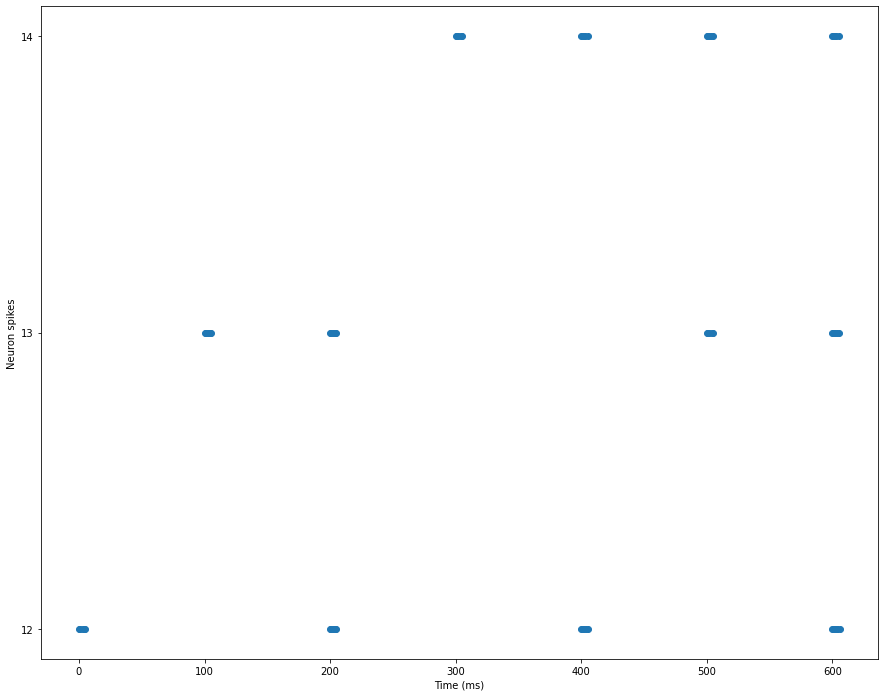

In [40]:
#if not(experiment == 5):
# Plot the spikes events in time 
import matplotlib.pyplot as plt

plt.figure(figsize=(15,12))
#plt.ylim([0, 40])
plt.yticks(list(set(events_neuron_id)))
#plt.xticks(list(set(events_timestamp)))
#plt.xlim([-5, 15])

plt.xlabel("Time (ms)")
plt.ylabel("Neuron spikes")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.plot(events_timestamp, events_neuron_id,"o")
plt.savefig("results/decoder.png", bbox_inches='tight')
plt.show()

In [42]:
# Close the device
close = False
if close:
    samna.device.close_device(model)